In [1]:
import json
import xarray as xr
import rioxarray
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
from fiweps.util import coordutil as co
from fiweps.util import regridutils as rgrd

## Configuration and prep

### Directories and files

In [2]:
configdir = Path("../config/dscale/")

with open(configdir / "domains_03_extent.json") as src:
    extent = json.load(src)
extent

{'d01': {'west': 161, 'east': -108, 'north': 76, 'south': 50},
 'd02': {'west': -178, 'east': -128, 'north': 72, 'south': 55}}

In [3]:
co.deg180_360(extent['d01']['east'])

252

In [4]:
datadirERA = Path("/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/")
borealmaskdir = Path("/Volumes/FIBOREAL/fiweps_data/GIS/raster_masks/era5_boreal_tundra_mask.nc")


In [5]:
julysnowfiles = sorted(list(datadirERA.glob('*07.nc')))
aprilsnowfiles = sorted(list(datadirERA.glob('*04.nc')))
julysnowfiles

[PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1960_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1961_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1962_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1963_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1964_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1965_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1966_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysi

In [6]:
cmap = plt.get_cmap('Blues', 5)

### Helper functions

In [7]:
def get_2Dtemplate(ds, roimask_in=None):
    template_data = np.ones((len(ds.latitude), len(ds.longitude)))
    template_lats = ds.latitude
    template_lons = ds.longitude
    templateDS = xr.DataArray(template_data, 
        coords=[template_lats, template_lons], 
        dims=["latitude", "longitude"])
    if roimask_in is not None:
        templateDS = templateDS.where(roimask_in==1)
    return templateDS

def get_subsetted_array(ds, extent):
    return ds.sel(
    latitude=slice(extent['d01']['north'], extent['d01']['south']),
    longitude=slice(co.deg180_360(extent['d01']['west']), co.deg180_360(extent['d01']['east']))
    )

### Get boreal mask

In [8]:
roimask_in = rgrd.get_mask().boreal_tundra_mask
roimask_in

<xarray.DataArray 'boreal_tundra_mask' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=int8]
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    grid_mapping:  crs
    description:   Location of boreal forest or tundra

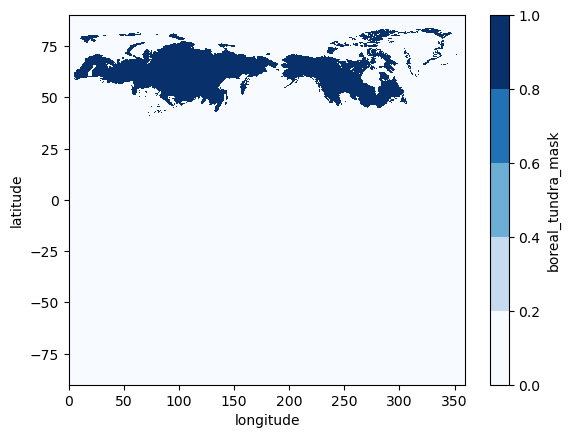

In [9]:
roimask_in.plot(cmap=cmap)

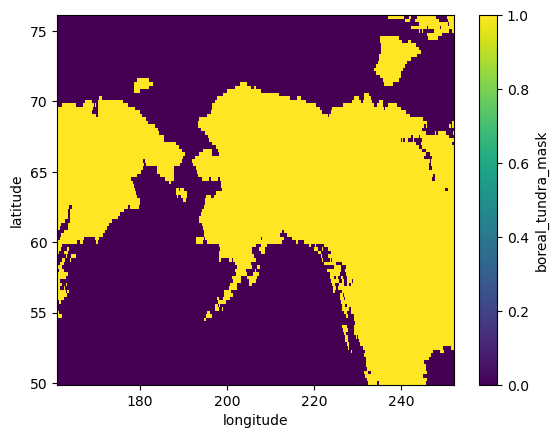

In [10]:
get_subsetted_array(roimask_in, extent).plot()

In [11]:
roimask_in

<xarray.DataArray 'boreal_tundra_mask' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=int8]
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    grid_mapping:  crs
    description:   Location of boreal forest or tundra

## make glacier mask

We'll make one glacier mask for each threshold and each year, from the first July dataset of every year. Since summer and winter are flipped between heispheres, we'll only do this for our boreal/Arctic area of interest. 

In [12]:
thresholds = np.arange(1.0, 7.0)        # look at 1m ... 6m 
outdir = Path("/Volumes/CWMobileSSD/Climate/ERA5/working")


### Make individual year / thresh glacier masks

In [12]:
for thresh in thresholds:
    outpth = outdir / f"thresh_{int(thresh)}m"
    outpth.mkdir(parents=True, exist_ok=True)
    print(f"Working on threshold = {thresh}, writing to {outpth}. ")
    for fpth in julysnowfiles:
        yr = fpth.stem[-7:-3]
        print(f"Working on year {yr}")
        with xr.open_dataset(fpth, chunks='auto') as ds:
            july_sd_era5 = ds.sd.isel(time=0)
            templ = get_2Dtemplate(ds, roimask_in=roimask_in)
        templ = templ.where(july_sd_era5 > thresh)
        templ = rgrd.attach_basicmetadata(templ)
        templ = templ.rename("glaciermask")
        templ = templ.fillna(0)
        templ = templ.astype('int')
        templ.attrs['title'] = f"ERA5-gridded glacier mask for year={yr} and threshold={thresh} for snow water equiv"
        outfpth = outpth / f"glaciermask_{yr}.nc"
        templ.to_netcdf(outfpth, 
            engine='netcdf4', encoding={
            'glaciermask':{'zlib': True,'complevel': 2}})
        print(f"Wrote {outfpth}")
        
        
            

Working on threshold = 1.0, writing to /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m. 
Working on year 1959
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1959.nc
Working on year 1960
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1960.nc
Working on year 1961
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1961.nc
Working on year 1962
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1962.nc
Working on year 1963
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1963.nc
Working on year 1964
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1964.nc
Working on year 1965
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1965.nc
Working on year 1966
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1966.nc
Working on year 1967
Wrote /Volumes/CWMobileSSD/Climate/ERA5/working/thresh_1m/glaciermask_1967.nc
Working on year 

### Make one glacier mask for each threshold

In [23]:
workpth = outdir


for thresh in thresholds:
    print(f"Working on threshold = {int(thresh)}")
    mfds = xr.open_mfdataset(str(workpth / f"thresh_{int(thresh)}m/*.nc"), combine='nested', concat_dim='time') 
    combined = mfds.any(dim='time').glaciermask
    combined = rgrd.attach_basicmetadata(combined)
    combined.attrs['title'] = f"ERA5-gridded glacier mask for threshold={thresh} for snow water equiv, years combined"
    combined.attrs['title'] = f"ERA5-gridded glacier mask for threshold={thresh} for snow water equiv, years combined"
    combined.to_netcdf(workpth / f"glaciermask_thresh_{int(thresh)}m.nc", 
        engine='netcdf4', encoding={
        'glaciermask':{'zlib': True,'complevel': 2}})


Working on threshold = 1
Working on threshold = 2
Working on threshold = 3
Working on threshold = 4
Working on threshold = 5
Working on threshold = 6


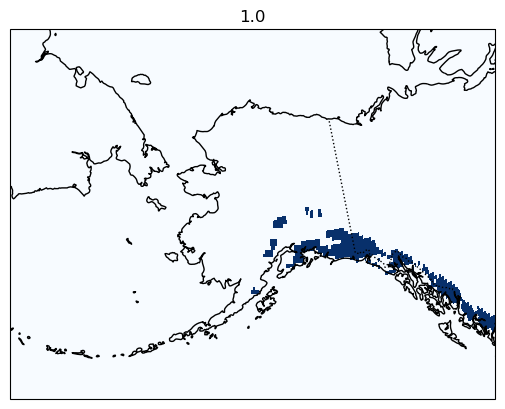

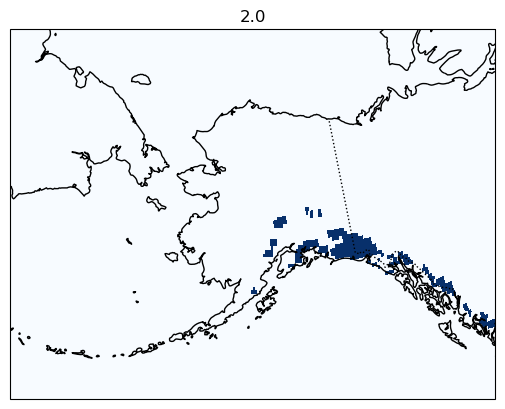

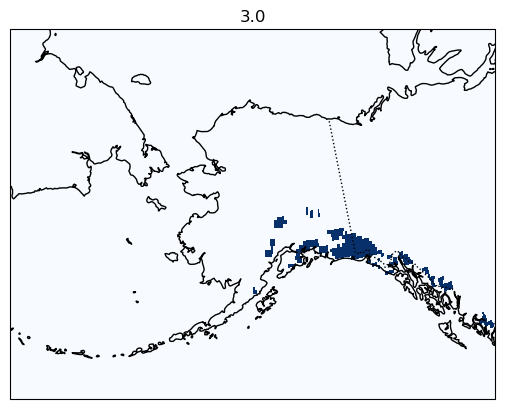

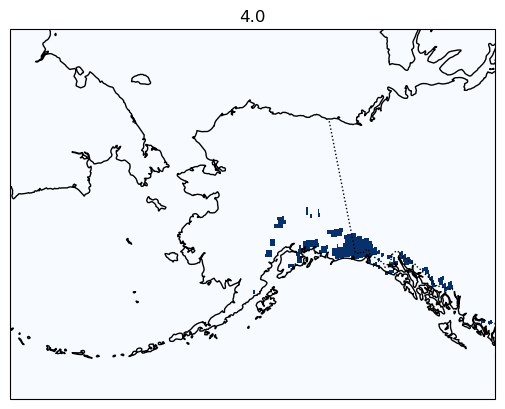

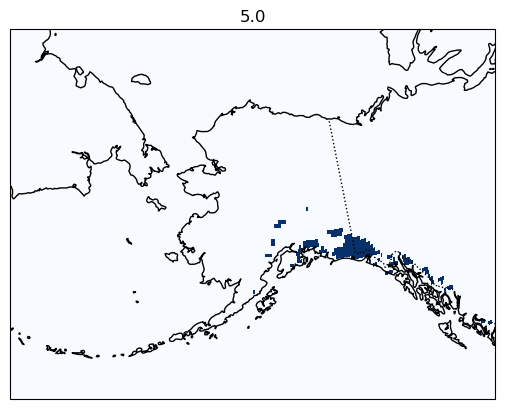

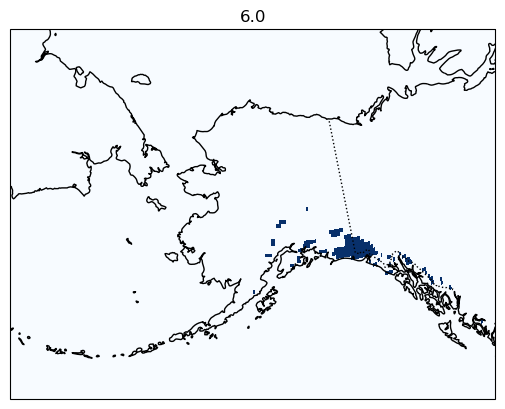

In [24]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))

for thresh in thresholds:
    ax = plt.axes(projection=projection)
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    with xr.open_dataarray(outdir / f"glaciermask_thresh_{int(thresh)}m.nc") as combined:
        combined.plot(
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            ax=ax,
        )
    ax.set_title(f"{thresh}")
    plt.show()



In [44]:
combined.sum().data.item()

4814

## Make data series measuring SD (snow-water equivalent) in the glaciermask area 

In [31]:
sumsnow = []

for thresh in thresholds:
    print(f"Working on threshold = {thresh}")
    newsnow = {}
    newsnow['threshold'] = int(thresh)
    with xr.open_dataarray(outdir / f"glaciermask_thresh_{int(thresh)}m.nc") as glaciermask:
        for fpth in julysnowfiles:
            yr = fpth.stem[-7:-3]
            try:
                newsnow['year'].append(int(yr))
            except KeyError:
                newsnow['year'] = [int(yr)]
            with xr.open_dataset(fpth, chunks='auto') as ds:
                july_sd_era5 = ds.sd.isel(time=0)
            july_sd_era5 = july_sd_era5.where(glaciermask==1)
            # global
            glaciersnow = july_sd_era5.sum(skipna=True).compute().data.item()
            try: 
                newsnow['globalglaciersnow'].append(glaciersnow)
            except KeyError:
                newsnow['globalglaciersnow'] = [glaciersnow]
            # subsetted to AK
            july_sd_era5 = get_subsetted_array(july_sd_era5, extent)
            glaciersnow = july_sd_era5.sum(skipna=True).compute().data.item()
            try: 
                newsnow['AKglaciersnow'].append(glaciersnow)
            except KeyError:
                newsnow['AKglaciersnow'] = [glaciersnow]
        fullcount = glaciermask.sum().data.item()
        newsnow['glacierpix_global'] = fullcount
        glaciermask_AK = get_subsetted_array(glaciermask, extent)
        AKcount = glaciermask_AK.sum().data.item()
        newsnow['glacierpix_AK'] = AKcount
        newsnow['AKglaciersnow'] = np.array(newsnow['AKglaciersnow'])
        newsnow['globalglaciersnow'] = np.array(newsnow['globalglaciersnow'])
        sumsnow.append(newsnow)


Working on threshold = 1.0
Working on threshold = 2.0
Working on threshold = 3.0
Working on threshold = 4.0
Working on threshold = 5.0
Working on threshold = 6.0


In [36]:
len(sumsnow)

6

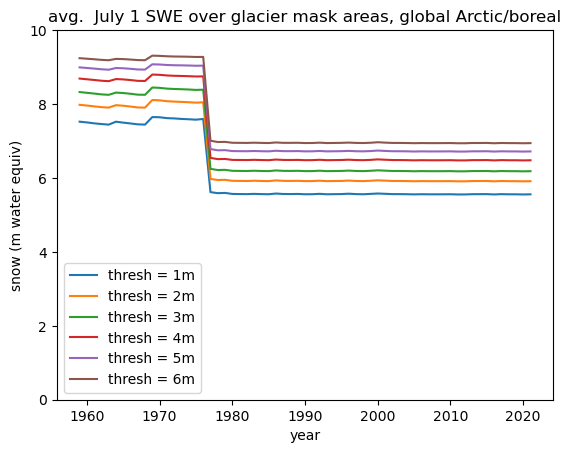

In [48]:
for thresh in thresholds:
    data = sumsnow[int(thresh)-1]
    plt.plot(data['year'], data['globalglaciersnow']/data['glacierpix_global'], label=f"thresh = {int(thresh)}m")
    plt.legend()
    plt.ylabel("snow (m water equiv)")
    plt.xlabel("year")
    plt.title("avg.  July 1 SWE over glacier mask areas, global Arctic/boreal")
    plt.ylim((0,10))

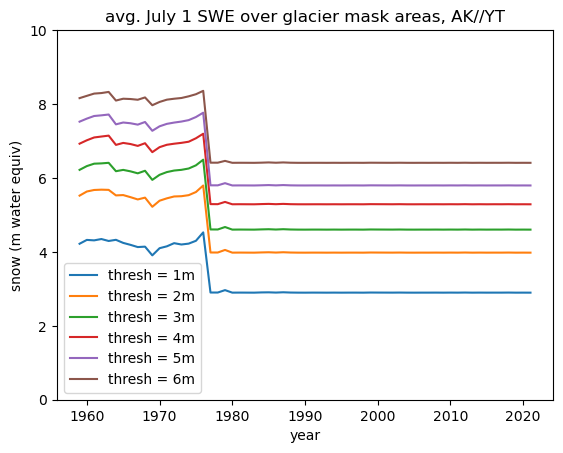

In [50]:
for thresh in thresholds:
    data = sumsnow[int(thresh)-1]
    plt.plot(data['year'], data['AKglaciersnow']/data['glacierpix_AK'], label=f"thresh = {int(thresh)}m")
    plt.legend()
    plt.ylabel("snow (m water equiv)")
    plt.xlabel("year")
    plt.title("avg. July 1 SWE over glacier mask areas, AK//YT")
    plt.ylim((0,10))

Text(0.5, 0, 'threshold')

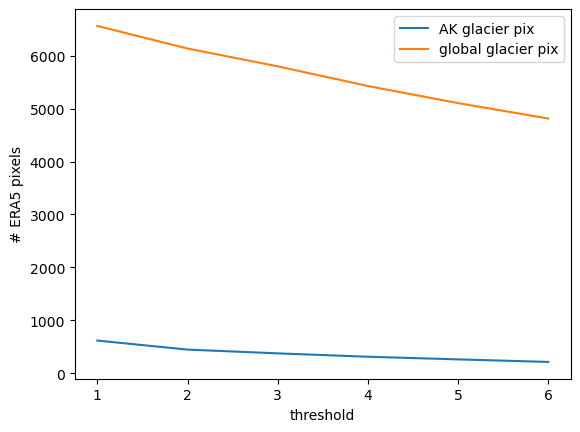

In [47]:
glacierpix_AK = [item['glacierpix_AK'] for item in sumsnow]
glacierpix_global = [item['glacierpix_global'] for item in sumsnow]
plt.plot(thresholds, glacierpix_AK, label=f"AK glacier pix")
plt.plot(thresholds, glacierpix_global, label=f"global glacier pix")
plt.legend()
plt.ylabel("# ERA5 pixels")
plt.xlabel("threshold")


## Prototyping code area

In [1]:
julysnowfiles[20].stem[-7:-3]

NameError: name 'julysnowfiles' is not defined

In [20]:
ds = xr.open_dataset(julysnowfiles[20], chunks='auto')
july_sd_era5 = ds.sd.isel(time=0)
july_sd_era5_mean = ds.sd.mean(dim="time")
july_sd_era5.where(july_sd_era5 > 1)



<xarray.DataArray 'sd' (latitude: 721, longitude: 1440)>
dask.array<where, shape=(721, 1440), dtype=float32, chunksize=(253, 506), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 1979-07-01
Attributes:
    units:          m of water equivalent
    long_name:      Snow depth
    standard_name:  lwe_thickness_of_surface_snow_amount

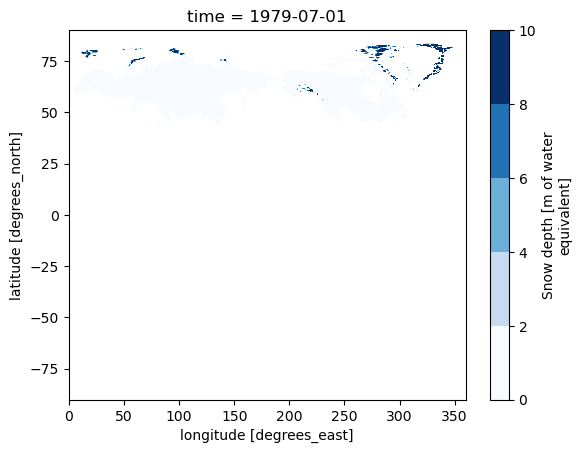

In [20]:
july_sd_era5.where(roimask_in==1).plot(cmap=cmap)

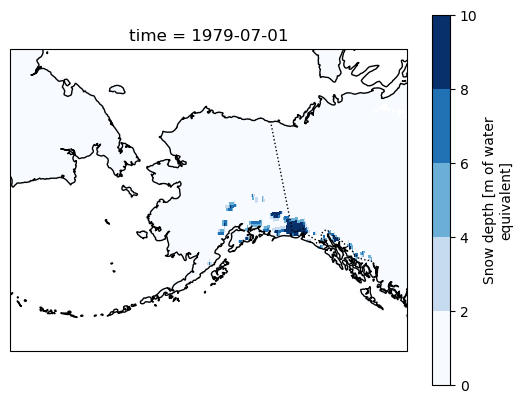

In [21]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
july_sd_era5.where(roimask_in==1).plot(
    cmap=cmap,
    transform=ccrs.PlateCarree(),
#    add_colorbar=False,
    ax=ax,
)


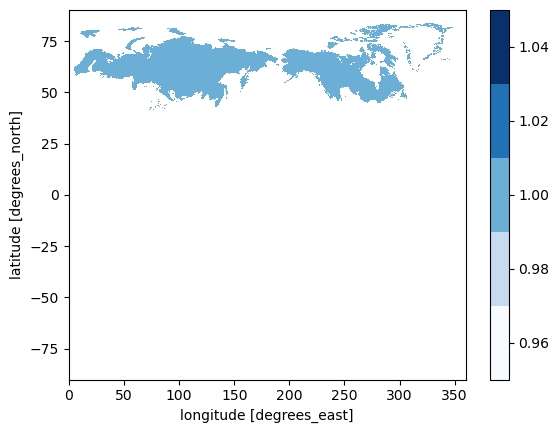

In [38]:
templ = get_2Dtemplate(ds, roimask_in=roimask_in)
templ.plot(cmap=cmap)

In [39]:
templ

<xarray.DataArray (latitude: 721, longitude: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [40]:
templ = templ.where(july_sd_era5 > 1)
#templ = rgrd.attach_basicmetadata(templ)
templ = templ.rename("glaciermask")
templ = templ.fillna(0)
templ = templ.astype('int')

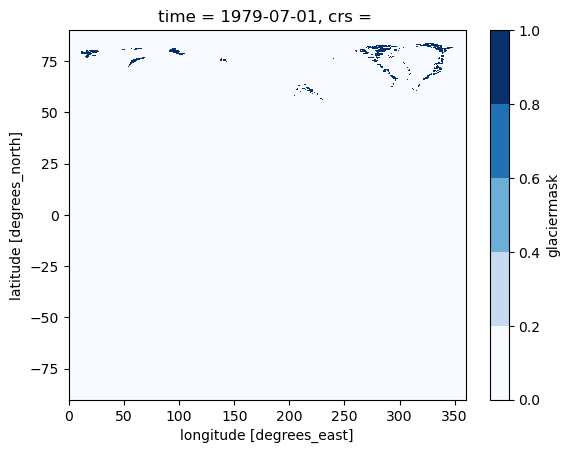

In [49]:
templ.plot(cmap=cmap)

In [47]:
rgrd.attach_basicmetadata(templ)

<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
dask.array<astype, shape=(721, 1440), dtype=int64, chunksize=(253, 506), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    time       datetime64[ns] 1979-07-01
    crs        <U1 ''
Attributes:
    title:        An ERA5-shaped dataset from the UAF FiWePs team
    institution:  International Arctic Research Center, UAF
    source:       Python, data file version  0.9
    author:       Chris Waigl cwaigl@alaska.edu 
    history:      2023-02-02 04:16:23.630725

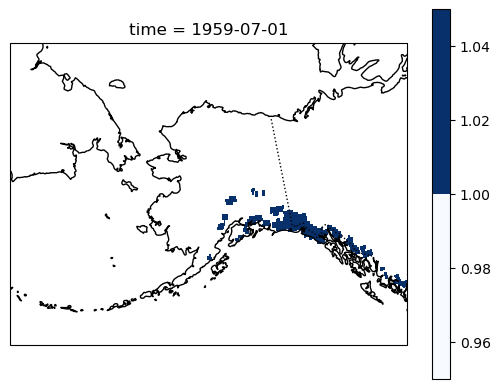

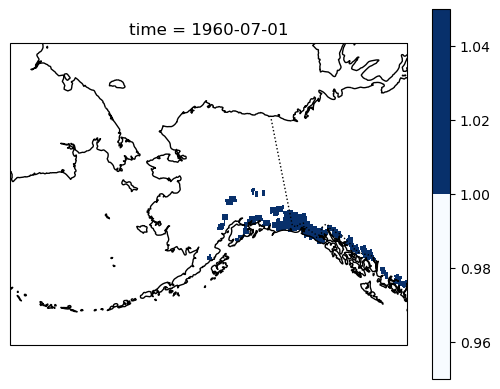

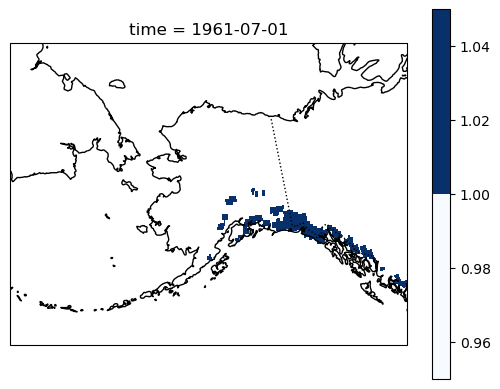

Exception ignored in: <function CachingFileManager.__del__ at 0x10a849440>
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 248, in __del__
    self.close(needs_lock=False)
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/xarray/backends/file_manager.py", line 232, in close
    file.close()
  File "src/netCDF4/_netCDF4.pyx", line 2624, in netCDF4._netCDF4.Dataset.close
  File "src/netCDF4/_netCDF4.pyx", line 2587, in netCDF4._netCDF4.Dataset._close
  File "src/netCDF4/_netCDF4.pyx", line 2028, in netCDF4._netCDF4._ensure_nc_success
RuntimeError: Bad file descriptor


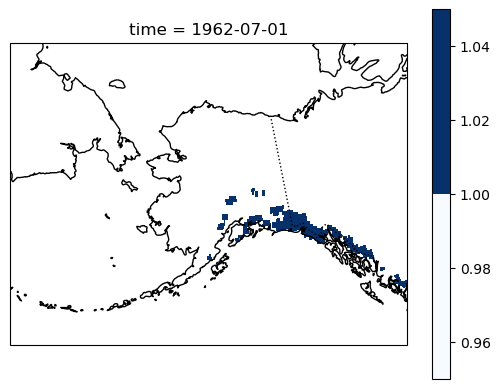

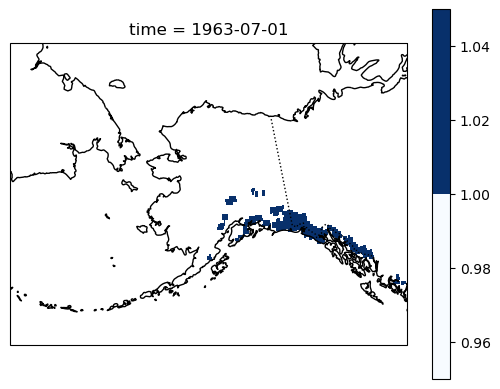

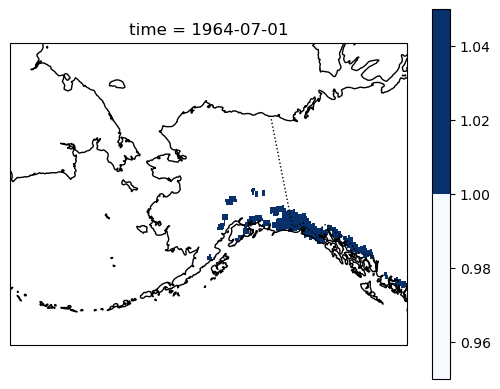

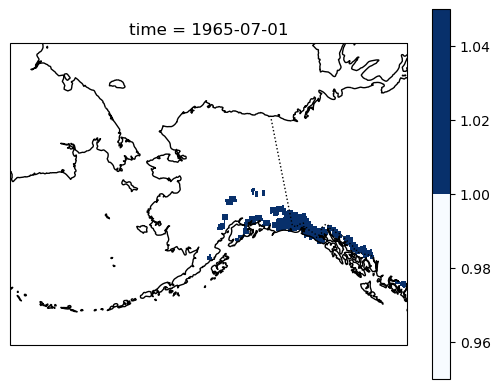

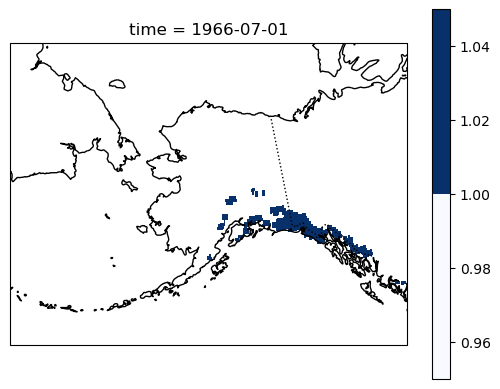

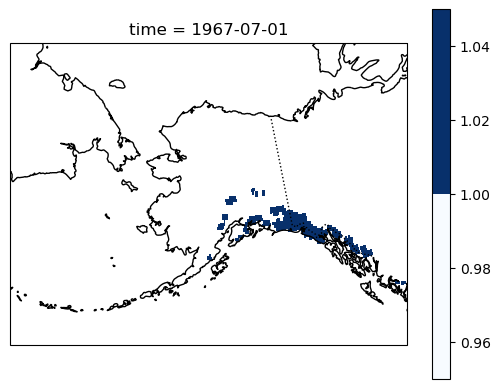

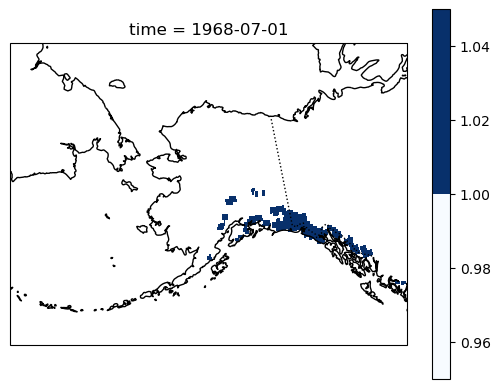

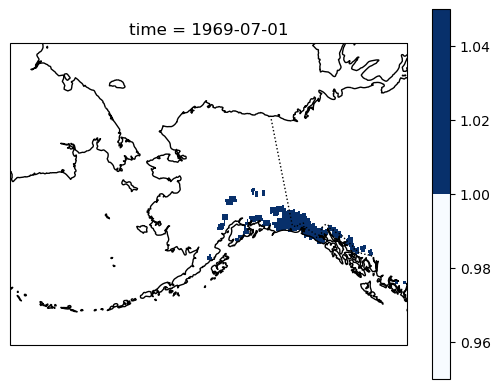

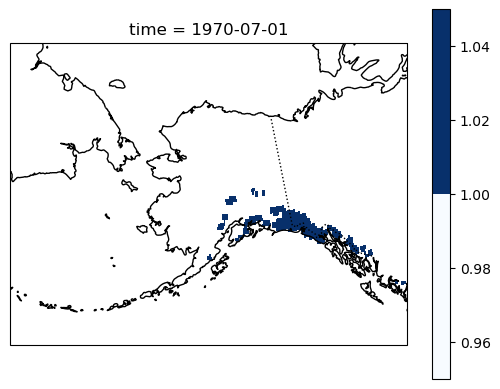

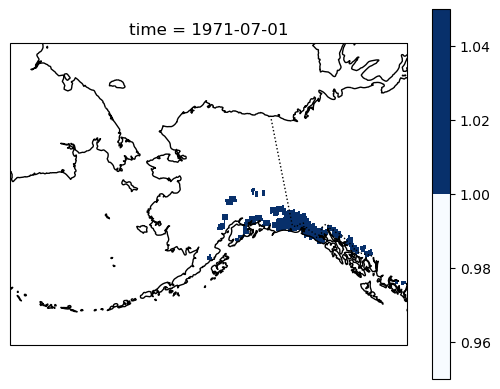

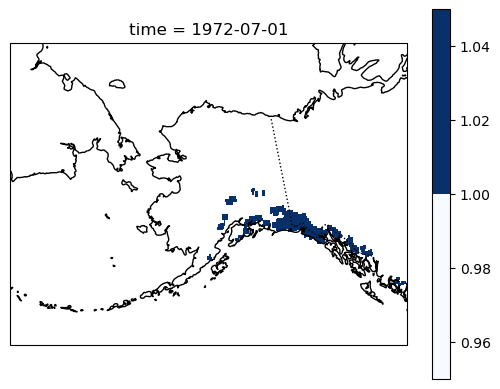

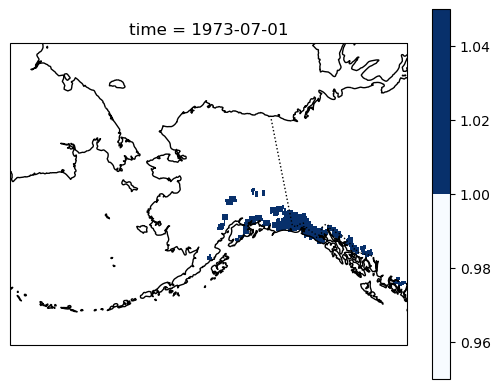

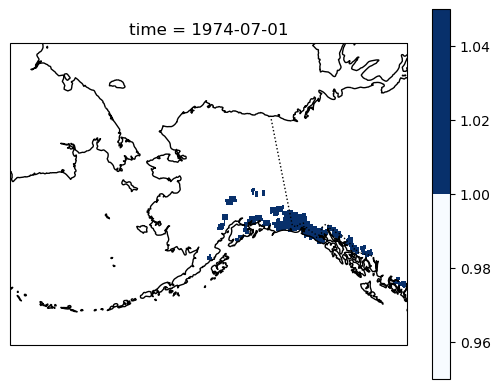

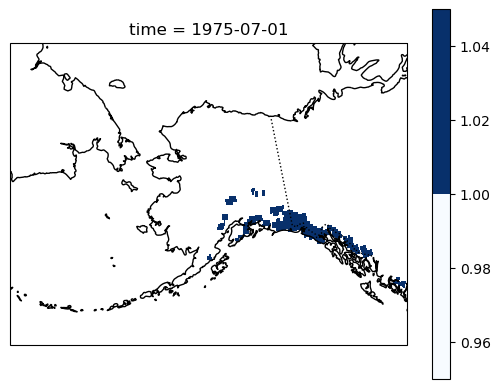

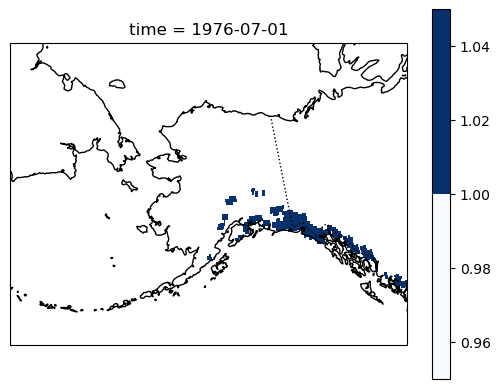

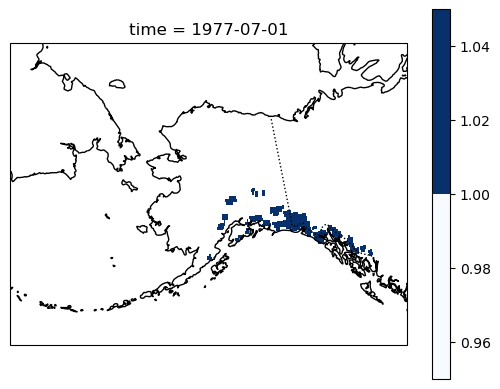

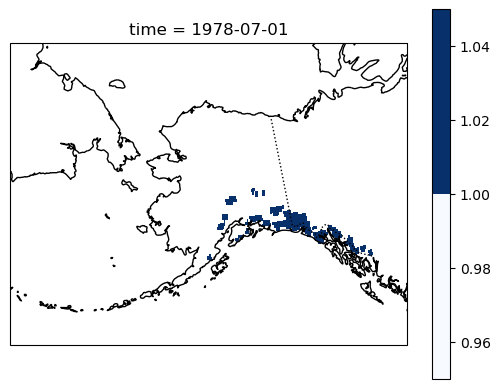

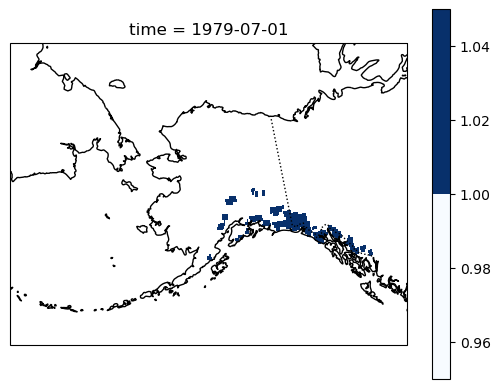

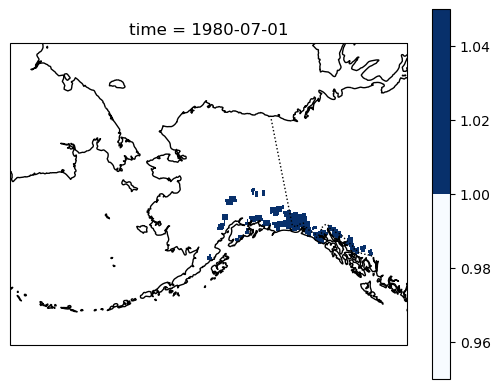

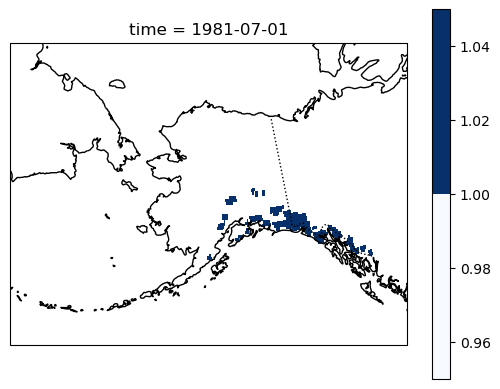

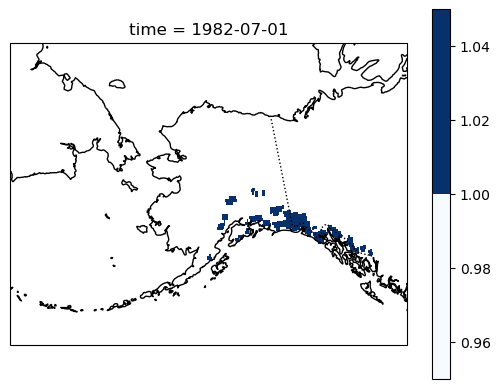

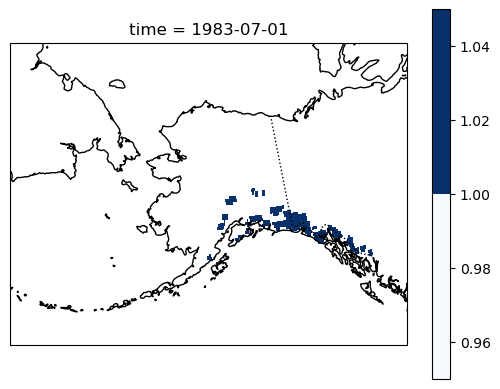

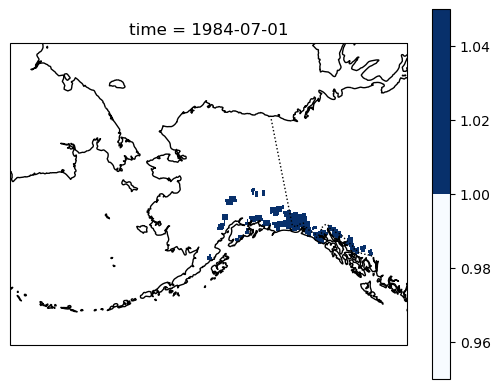

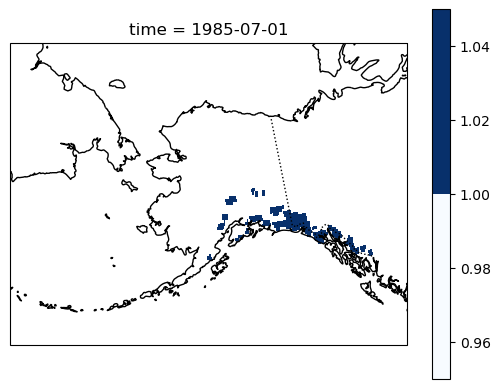

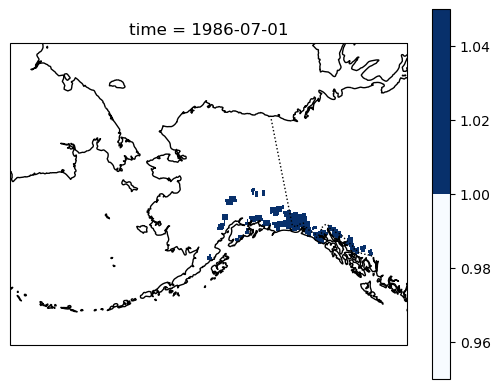

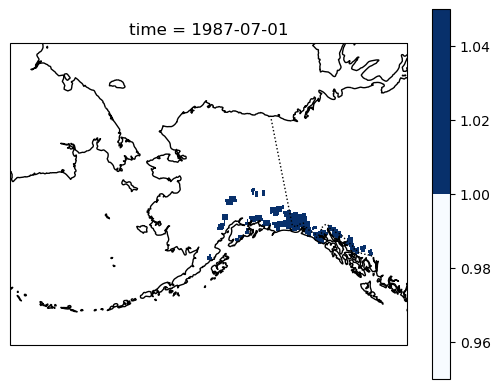

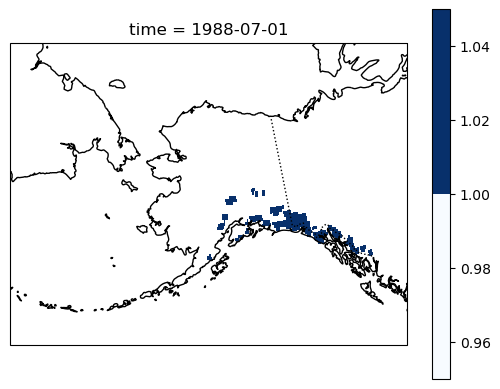

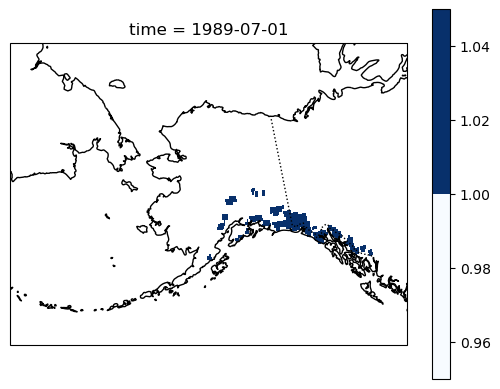

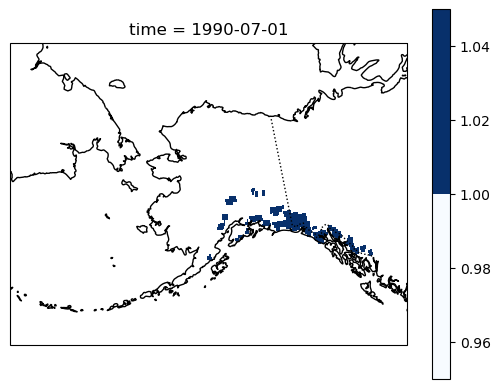

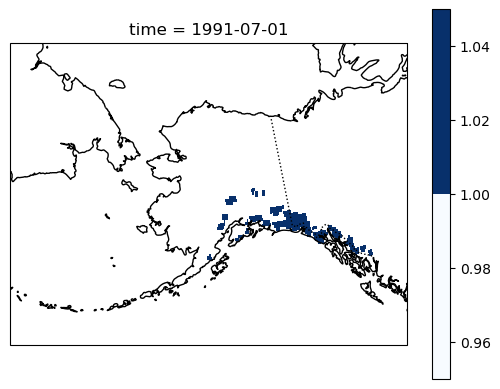

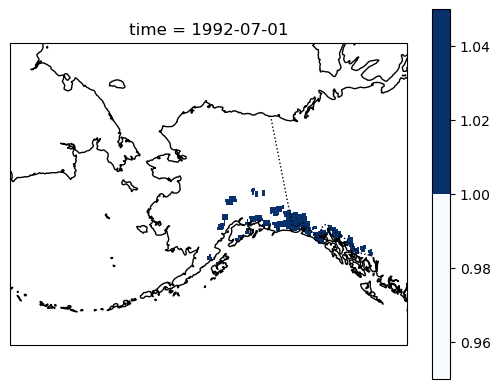

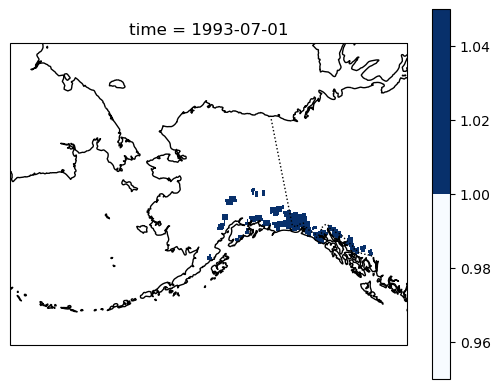

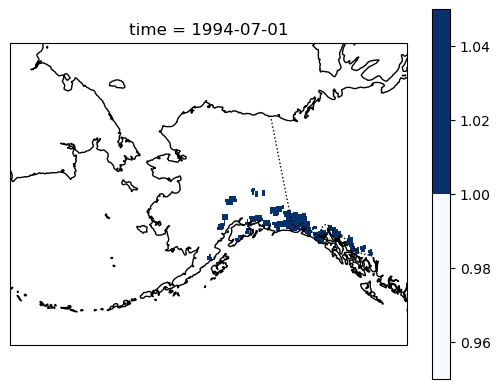

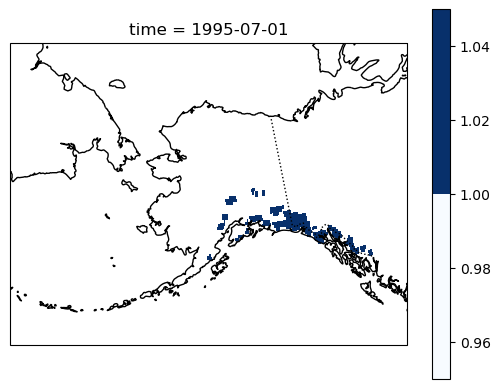

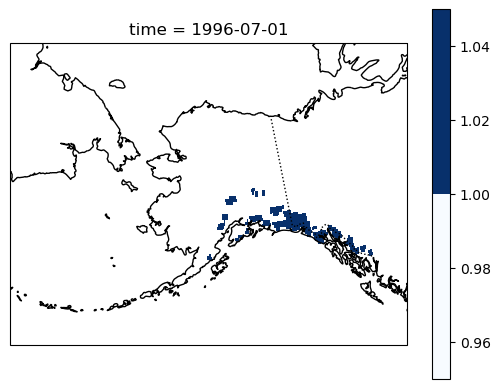

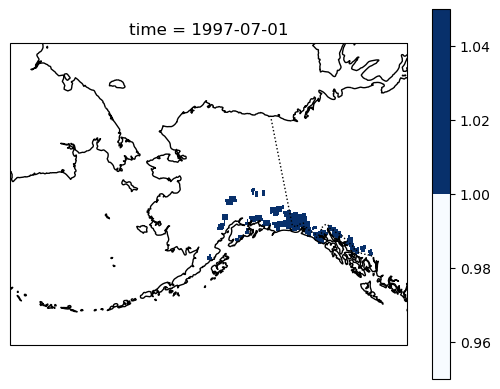

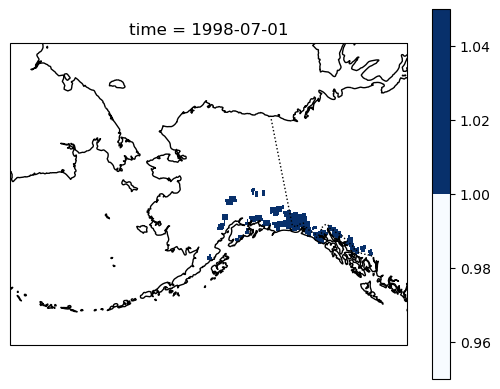

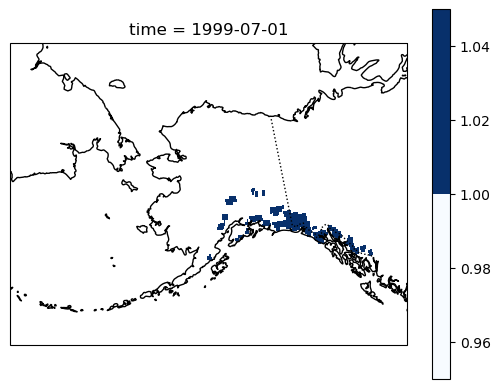

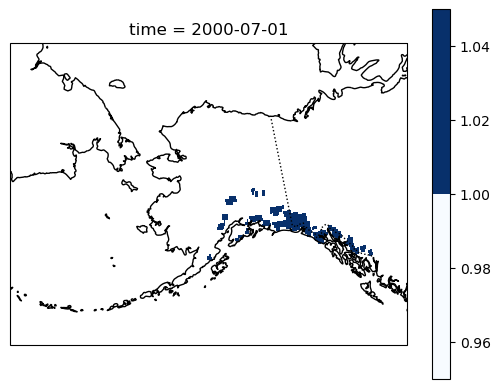

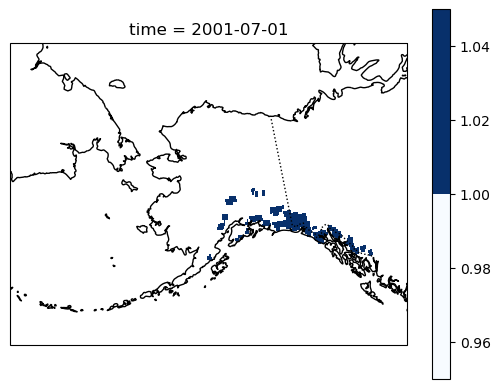

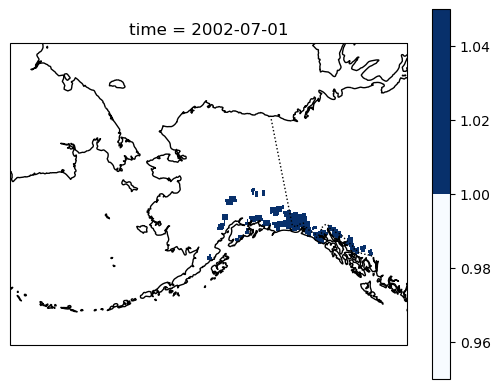

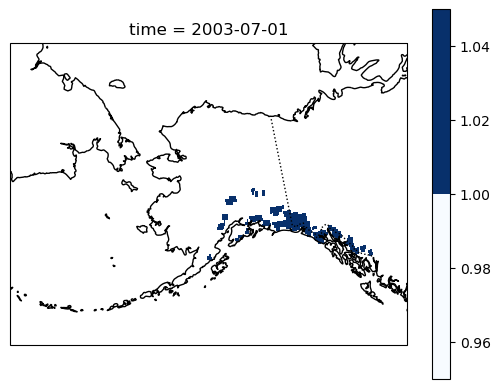

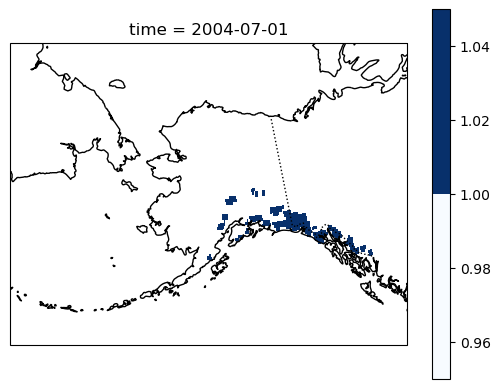

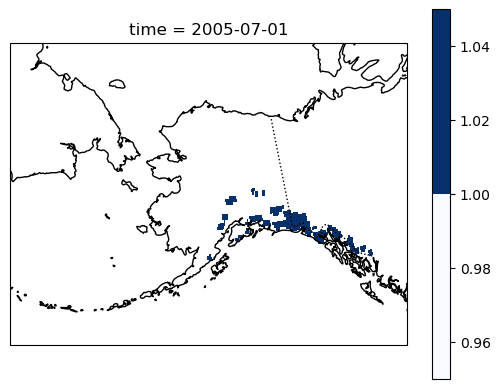

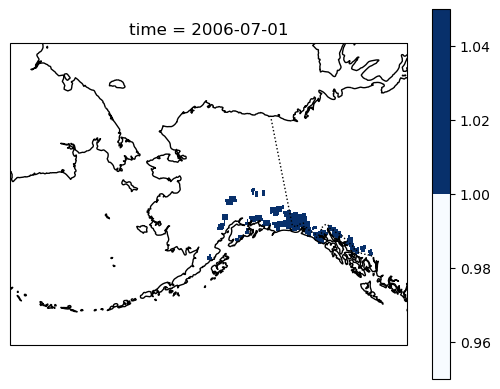

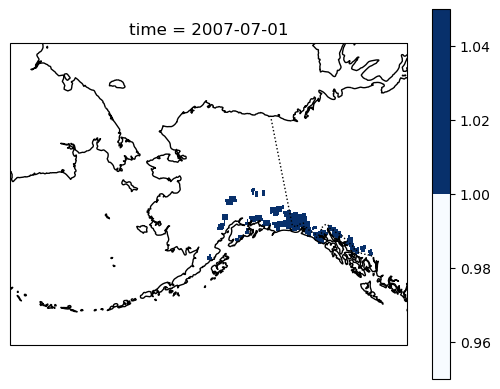

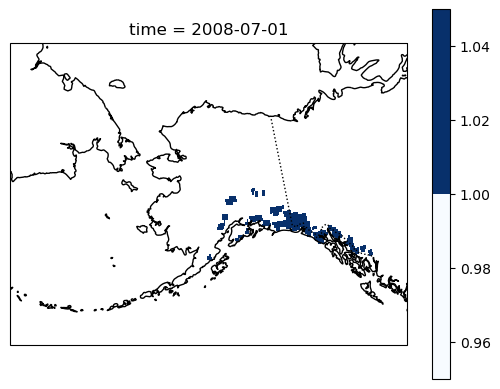

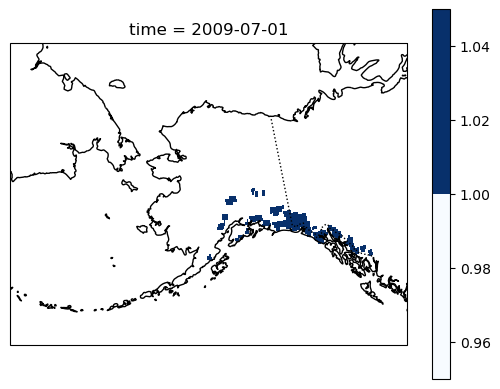

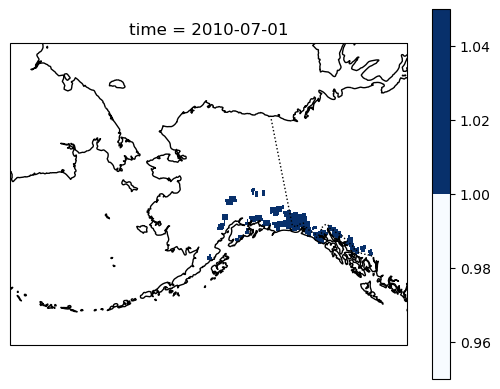

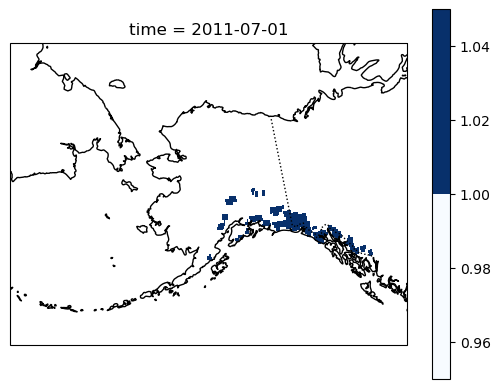

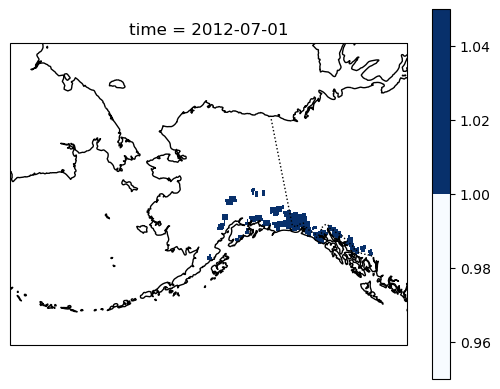

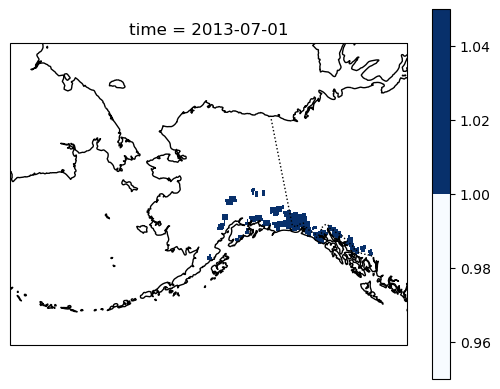

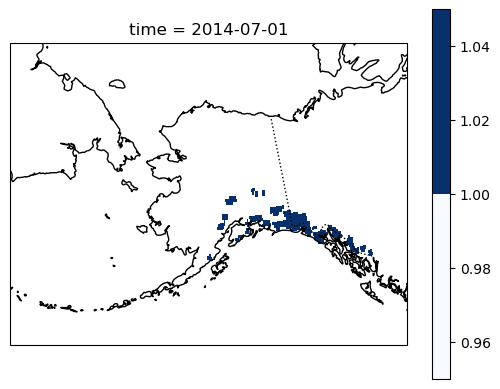

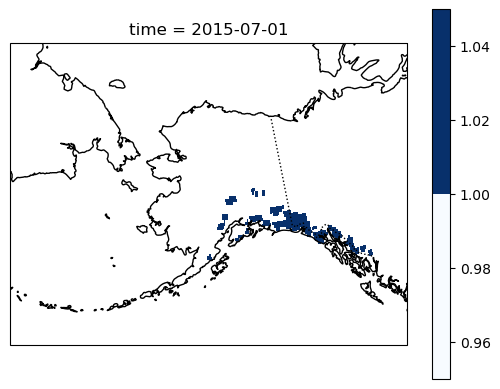

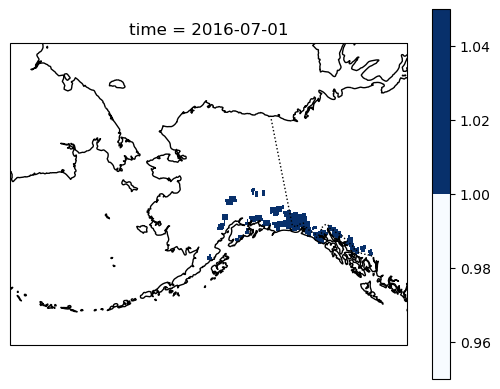

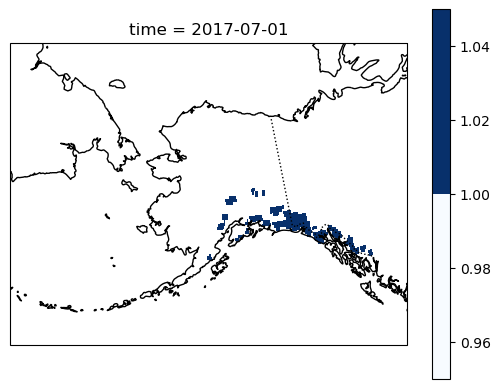

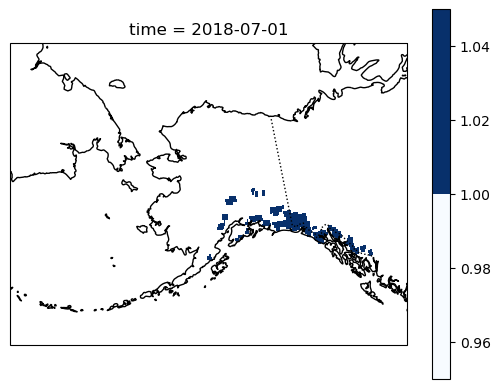

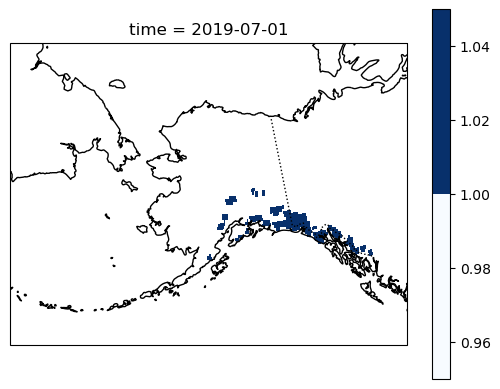

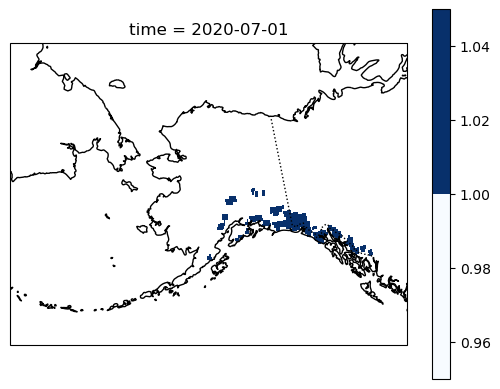

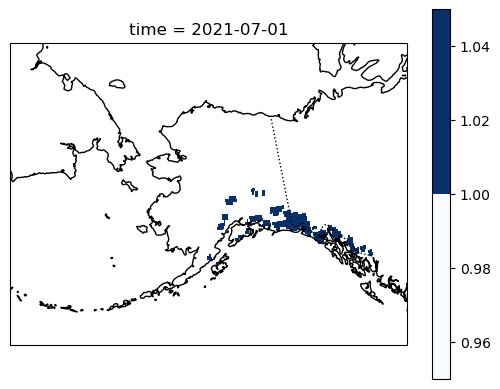

In [115]:
thresh = 2.0

projection = ccrs.AlbersEqualArea(
central_longitude=-154.0, central_latitude=50.0, 
standard_parallels=(55.0, 65.0))

for pth in julysnowfiles[:]:
    ds = xr.open_dataset(pth, chunks='auto')
    july_sd_era5 = ds.sd.isel(time=0)
    templateDS = get_2Dtemplate(ds)
    templateDS = templateDS.where(july_sd_era5 > thresh)

    ax = plt.axes(projection=projection)
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    templateDS.plot(
#    july_sd_era5.plot(
    cmap=plt.get_cmap('Blues', 2),
    transform=ccrs.PlateCarree(),
#    add_colorbar=False,
    ax=ax,
    )
    plt.show()

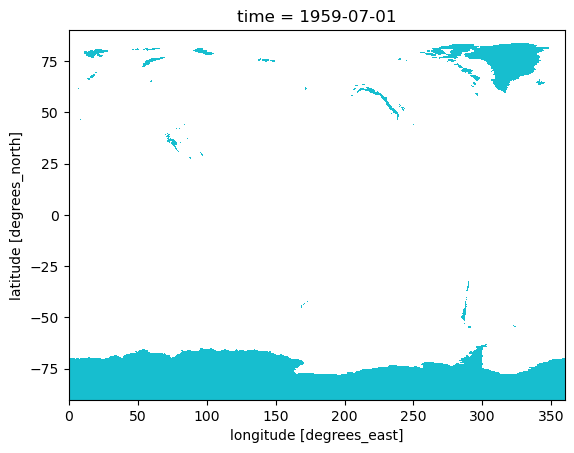

In [29]:
templateDS = templateDS.where(july_sd_era5 > 0.1, 0)
templateDS.where(templateDS==1).plot(levels=2, cmap=cmap, add_colorbar=False)

In [ ]:
templateDS

<xarray.DataArray (latitude: 721, longitude: 1440)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [ ]:
projection = ccrs.AlbersEqualArea(
central_longitude=-154.0, central_latitude=50.0, 
standard_parallels=(55.0, 65.0))



JRA55_pths = sorted(datadirJRA.glob("anl_land.065_*8"))
ERA5_pths = sorted(datadirERA.glob("e5.oper.an.sfc*.grb"))
datapairs = list(zip(JRA55_pths, ERA5_pths))[:1] 
fig, axs = plt.subplots(nrows=len(datapairs),ncols=,
                        subplot_kw={'projection': projection},
                        figsize=(15,5))
for ax in axs.flatten():
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')

for idx, dsJRA, dsERA in enumerate(datapairs): 
    with xr.open_dataset(dsERA, engine="cfgrib") as ds_ERA:
        with xr.open_dataset(dsJRA, engine="cfgrib") as ds_JRA:
            
            ds_JRA_ERA = ds.fillna(0).interp(
                latitude=ds_ERA.latitude, longitude=ds_ERA.longitude, method='nearest') / 1000
            combined_DS = ds_ERA.sd.where(templateDS==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))

month number 1
month number 2
month number 3


Can't read index file '/Volumes/CWMobileSSD/Climate/ERA5/sd_grib/e5.oper.an.sfc.128_141_sd.ll025sc.2021040100_2021043023.grb.923a8.idx'
Traceback (most recent call last):
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 547, in from_indexpath_or_filestream
    self = cls.from_indexpath(indexpath)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/christine/miniconda3/envs/dyndown/lib/python3.11/site-packages/cfgrib/messages.py", line 429, in from_indexpath
    index = pickle.load(file)
            ^^^^^^^^^^^^^^^^^
EOFError: Ran out of input


month number 4
month number 5
month number 6


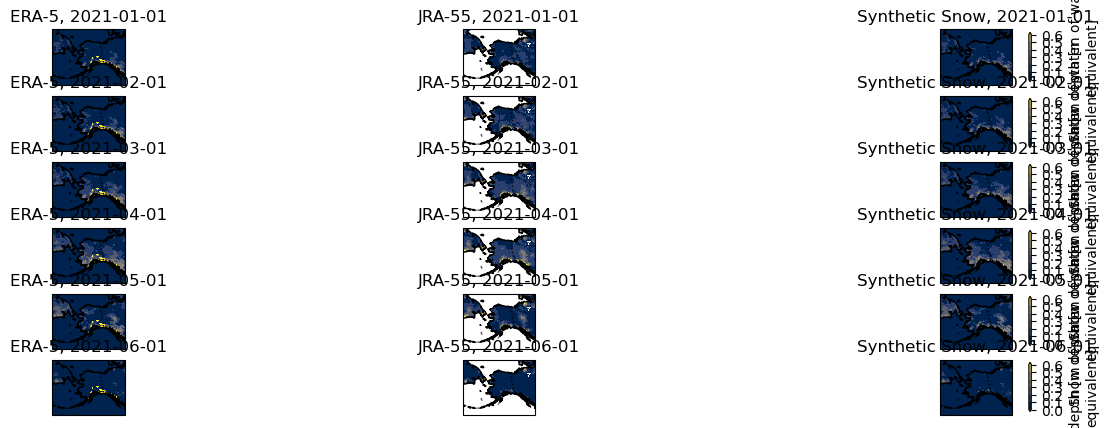

In [82]:
projection = ccrs.AlbersEqualArea(
central_longitude=-154.0, central_latitude=50.0, 
standard_parallels=(55.0, 65.0))


JRA55_pths = sorted(datadirJRA.glob("anl_land.065_*8"))
ERA5_pths = sorted(datadirERA.glob("e5.oper.an.sfc*.grb"))
datapairs = list(zip(JRA55_pths, ERA5_pths))
fig, axs = plt.subplots(nrows=len(datapairs),ncols=3,
                        subplot_kw={'projection': projection},
                        figsize=(15,5))
for ax in axs.flatten():
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')


for idx, (dsJRA, dsERA) in enumerate(datapairs): 
    print(f"month number {idx+1}")
    with xr.open_dataset(dsERA, engine="cfgrib") as ds_ERA:
        with xr.open_dataset(dsJRA, engine="cfgrib") as ds_JRA:
            ds_ERA.sd.isel(time=0).plot(
                cmap=cmap, norm=norm, 
                add_colorbar=False,
#                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][0],
            )
            axs[idx][0].set_title(f"ERA-5, {ds_ERA.time[0].dt.strftime('%Y-%m-%d').data}")
            plotraster = ds_JRA.sd.isel(time=0) / 1000
            plotraster.plot(
                cmap=cmap, norm=norm, 
                add_colorbar=False,
#                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][1],
            )
            axs[idx][1].set_title(f"JRA-55, {ds_JRA.time[0].dt.strftime('%Y-%m-%d').data}")
            ds_JRA_ERA = ds_JRA.fillna(0).interp(
                latitude=ds_ERA.latitude, longitude=ds_ERA.longitude, method='nearest') / 1000
            combined_DS = ds_ERA.sd.where(templateDS==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))
            combined_DS.sd.plot(
                cmap=cmap, norm=norm, 
                cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
                transform=ccrs.PlateCarree(),
                ax=axs[idx][2],
            )
            axs[idx][2].set_title(f"Synthetic Snow, {ds_JRA.time[0].dt.strftime('%Y-%m-%d').data}")
            




In [11]:
maskoutdir = Path("/Volumes/CWMobileSSD/Climate/ERA5/masks/")

In [46]:
ds_ERA = xr.open_dataset(datadirNC / "reanalysis-era5-single-levels_sd_2021_06.nc")


In [13]:
ds_ERA.sd.isel(time=0)

<xarray.DataArray 'sd' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 2021-07-01
Attributes:
    units:          m of water equivalent
    long_name:      Snow depth
    standard_name:  lwe_thickness_of_surface_snow_amount

In [47]:
ds = xr.open_dataset(june_JRA55, engine="cfgrib")
ds.sd.isel(time=0)

<xarray.DataArray 'sd' (latitude: 320, longitude: 640)>
[204800 values with dtype=float32]
Coordinates:
    time        datetime64[ns] 2021-06-01
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.57 89.01 88.45 ... -88.45 -89.01 -89.57
  * longitude   (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    valid_time  datetime64[ns] ...
Attributes: (12/24)
    GRIB_paramId:                             228141
    GRIB_numberOfPoints:                      204800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_gg
    ...                                       ...
    GRIB_name:                                Snow depth water equivalent
    GRIB_shortName:                           sd
    GRIB_units:                               kg m**-2
    long_name:                                Snow depth water equivalent
    units:                                    kg m**-2
    standard_name:                            unknown

In [15]:
ds.sd

<xarray.DataArray 'sd' (time: 120, latitude: 320, longitude: 640)>
[24576000 values with dtype=float32]
Coordinates:
  * time        (time) datetime64[ns] 2021-06-01 ... 2021-06-30T18:00:00
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 89.57 89.01 88.45 ... -88.45 -89.01 -89.57
  * longitude   (longitude) float64 0.0 0.5625 1.125 1.688 ... 358.3 358.9 359.4
    valid_time  (time) datetime64[ns] ...
Attributes: (12/24)
    GRIB_paramId:                             228141
    GRIB_numberOfPoints:                      204800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_gg
    ...                                       ...
    GRIB_name:                                Snow depth water equivalent
    GRIB_shortName:                           sd
    GRIB_units:                               kg m**-2
    long_name:                                Snow depth water equivalent
    units:                                    kg m**-2
    standard_name:                            unknown

In [48]:
ds_ERA.sd.shape

(720, 721, 1440)

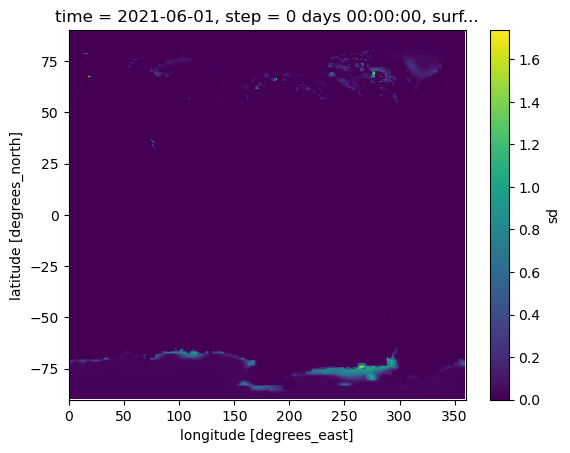

In [49]:
ds_JRA_ERA = ds.fillna(0).interp(
    latitude=ds_ERA.latitude, longitude=ds_ERA.longitude, method='nearest') / 1000
ds_JRA_ERA.sd.isel(time=0).plot()

In [50]:
combined_DS = ds_ERA.sd.where(templateDS==0).isel(time=0).combine_first(ds_JRA_ERA.isel(time=0))
combined_DS.sd.max()

<xarray.DataArray 'sd' ()>
array(1.5579224, dtype=float32)
Coordinates:
    time        datetime64[ns] 2021-06-01
    step        timedelta64[ns] 00:00:00
    surface     float64 0.0
    valid_time  datetime64[ns] 2021-06-01

In [51]:
bins = np.arange(0, 0.7, 0.1)
cmap = plt.get_cmap('cividis', len(bins))
#cmap = mpl.colors.ListedColormap(cmap.colors[[0] + idx])
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors)-1 )

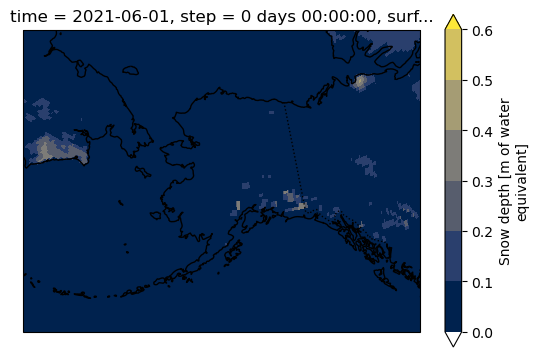

In [53]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
combined_DS.sd.plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

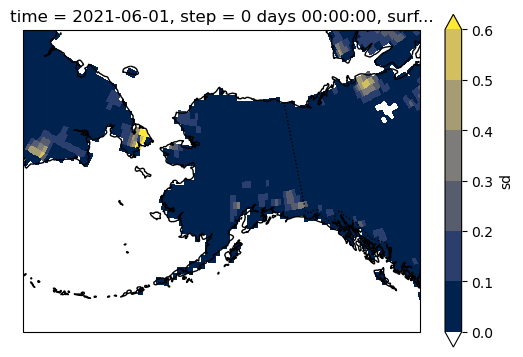

In [54]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
plotraster = ds.sd.isel(time=0) / 1000
plotraster.plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

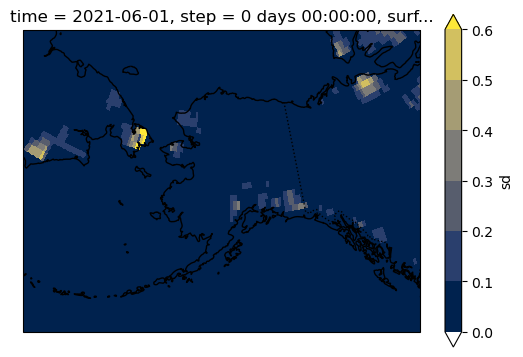

In [55]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_JRA_ERA.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

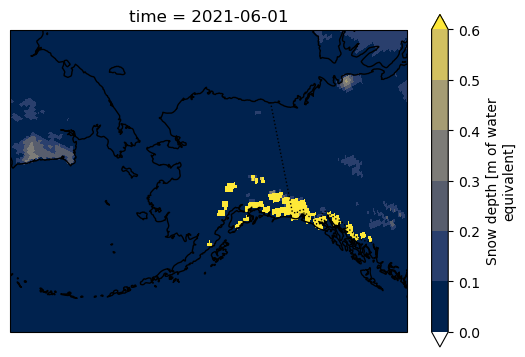

In [56]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
ds_ERA.sd.isel(time=0).plot(
    cmap=cmap, norm=norm, 
    cbar_kwargs={'ticks': bins, 'extend': 'both', "shrink": 0.9},
    transform=ccrs.PlateCarree(),
    ax=ax,
)

In [ ]:
outdir = Path("/Volumes/CWMobileSSD/Climate/figures")
fig.savefig(outdir / "JRA55_ERA5_SWE_comp01.png", bbox_inches="tight", dpi=200, facecolor='white')